In [1]:
import numpy
from airfoil_helper import *
from matplotlib import pyplot
%matplotlib inline

#### load the airfoil data

In [2]:
N = 200
main_csv = 'resources/MainFoil_N=' + str(N) + '.csv'
flap_csv = 'resources/FlapFoil_N=' + str(N) + '.csv'

In [3]:
x_m_ends, y_m_ends = numpy.loadtxt(main_csv, delimiter=',', unpack=True)
x_f_ends, y_f_ends = numpy.loadtxt(flap_csv, delimiter=',', unpack=True)

#### Generate the panels

In [4]:
def gen_panels(x_ends, y_ends):
    N = len(x_ends) - 1  
    panels = numpy.empty(N, dtype=object)
    for i in xrange(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    return panels

In [5]:
mains, flaps = gen_panels(x_m_ends, y_m_ends), gen_panels(x_f_ends, y_f_ends)
panels = numpy.concatenate((mains, flaps))

In [6]:
def plot_panels(panels, figname):
    """Plot the panels."""
    pyplot.grid(True)
    pyplot.axis('equal')
    pyplot.xlabel(r'$x$')
    pyplot.ylabel(r'$y$')
    pyplot.title(figname)
    pyplot.xlim(0., 1.4)
    pyplot.plot([panel.xa for panel in mains], [panel.ya for panel in mains], 'g-')
    pyplot.plot([panel.xa for panel in flaps], [panel.ya for panel in flaps], 'g-')
    pyplot.plot([panel.xa for panel in panels], [panel.ya for panel in panels], 'go', markersize=5.0, alpha=0.5)
    pyplot.plot([panel.xc for panel in panels], [panel.yc for panel in panels], 'rx', markersize=4.0);

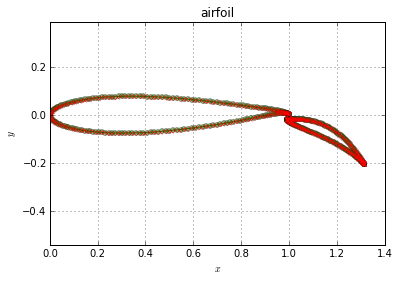

In [7]:
plot_panels(panels, 'airfoil')

#### Freestream condition

In [8]:
# add freestream velocity and AOA 
u_inf, alpha = 1.0, 0.0
freestream = Freestream(u_inf, alpha)

#### Build the coefficient matrix

In [9]:
def source_matrix(panels):
    """build the N*N source coefficient matrix"""
    a = numpy.zeros((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(a, 0.5)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                a[i, j] = 0.5/numpy.pi*integral(p_i, p_j, p_i.nx, p_i.ny)
    return a

In [10]:
def vortex_array(panels):
    """return N*2 vortex coefficient array"""
    N = panels.size
    mains = panels[:N/2]
    flaps = panels[N/2:]
    a = numpy.zeros((N, 2), dtype=float)
    # loop in evaluation panel i
    for i, p_i in enumerate(panels):
        # loop in main airfoil panel j
        for j, p_j in enumerate(mains):
            if i != j:    # jump if i,j are the same panel
                a[i, 0] -= 0.5/numpy.pi*integral(p_i, p_j, p_i.ny, - p_i.nx)
        # loop in flap airfoil panel j
        for j, p_j in enumerate(flaps):
            if i != (j+N/2):    # jump if i,j are the same panel
                a[i, 1] -= 0.5/numpy.pi*integral(p_i, p_j, p_i.ny, - p_i.nx)
    return a

In [11]:
def kutta_array(panels, a, b):
    """return N+2 x 1 array for main airfoil"""
    p_a, p_b = panels[a], panels[b]
    N = panels.size
    mains = panels[:N/2]
    flaps = panels[N/2:]
    A = numpy.zeros(N+2, dtype=float)
    
    # calculate the coefficient of source strength
    for j, p_j in enumerate(panels):
        if j != a:
            A[j] += 0.5/numpy.pi * integral(p_a, p_j, p_a.tx, p_a.ty)
        if j != b:
            A[j] += 0.5/numpy.pi * integral(p_b, p_j, p_b.tx, p_b.ty)
    
    # calculate the coefficient of vortex strength
    # if a,b on main airfoil
    if b <= N/2-1:
        # main airfoil
        for j, p_j in enumerate(mains):
            if j != a:
                A[-2] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            else:
                A[-2] -= 0.5
            if j != b:
                A[-2] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
            else:
                A[-2] -= 0.5
        # flap airfoil
        for j, p_j in enumerate(flaps):
            A[-1] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            A[-1] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
    
    # if a,b on flap airfoil
    elif a >= N/2:
        # main airfoil
        for j, p_j in enumerate(mains):
            A[-2] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            A[-2] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
        # flap airfoil
        for j, p_j in enumerate(flaps):
            if (j+N/2) != a:
                A[-1] -= 0.5/numpy.pi * integral(p_a, p_j, p_a.ty, -p_a.tx)
            else:
                A[-1] -= 0.5
            if (j+N/2) !=b :
                A[-1] -= 0.5/numpy.pi * integral(p_b, p_j, p_b.ty, -p_b.tx)
            else:
                A[-1] -= 0.5
    return A

In [12]:
def build_matrix(panels):
    N = panels.size
    A = numpy.empty((N+2, N+2), dtype=float)
    AS = source_matrix(panels)
    av = vortex_array(panels)
    k1 = kutta_array(panels, 0, N/2-1)
    k2 = kutta_array(panels, N/2, N-1)
    
    A[:N, :N] = AS[:,:]
    A[:N, N:] = av[:,:]
    A[-2, :] = k1[:]
    A[-1, :] = k2[:]
    
    return A

In [13]:
A = build_matrix(panels)

#### Build the RHS

In [14]:
def build_rhs(panels, freestream):
    N = panels.size
    b = numpy.zeros(N+2, dtype=float)
    for i, p_i in enumerate(panels):
        b[i] = - freestream.u_inf * numpy.cos(freestream.alpha - p_i.beta)
    # kutta condition main airfoil    
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha-panels[0].beta)
                               + numpy.sin(freestream.alpha-panels[N/2-1].beta))
    # kutta condition flap airfoil
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha-panels[N/2].beta)
                               + numpy.sin(freestream.alpha-panels[N-1].beta))
    return b

In [15]:
b = build_rhs(panels, freestream)

#### Solve the linear system

In [16]:
# solves the linear system
solution = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = solution[i]
gamma_m, gamma_f = solution[-2], solution[-1]

#### Check the accurary via source strength

In [17]:
# calculates the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print '--> sum of source/sink strengths:', accuracy

--> sum of source/sink strengths: -0.000826784259806


#### Calculate Surface tangential velocity

In [18]:
def tan_vel(panels, freestream, solution):
    """Calculate the tangential velocity for each panel"""
    N = len(panels)
    mains = panels[:N/2]
    flaps = panels[N/2:]
    A = numpy.zeros((N, N+2), dtype=float)
    b = numpy.zeros(N, dtype=float)
    for i, p_i in enumerate(panels):
        # freestream
        b[i] = freestream.u_inf * numpy.sin(freestream.alpha-p_i.beta)
        # source
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi *integral(p_i, p_j, p_i.tx, p_i.ty)
        # vortex
        # i on main
        if i < N/2:
            # main wing contribution
            for j, p_j in enumerate(mains):
                if i != j:
                    A[i, -2] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
                else:
                    A[i, -2] -= 0.5
            # flap wing contribution
            for j, p_j in enumerate(flaps):
                A[i, -1] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
        # i on flap
        else:
            # main wing contribution
            for j, p_j in enumerate(mains):
                A[i,-2] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
            # flap contribution
            for j, p_j in enumerate(flaps):
                if i != (j+N/2):
                    A[i,-1] -= 0.5/numpy.pi * integral(p_i, p_j, p_i.ty, -p_i.tx)
                else:
                    A[i,-1] -= 0.5
    
    vt = numpy.dot(A, solution) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [19]:
tan_vel(panels, freestream, solution)

In [20]:
def eval_cp(panels, freestream):
    for panel in panels:
        panel.cp = 1 - (panel.vt/freestream.u_inf)**2

In [21]:
eval_cp(panels,freestream)

In [22]:
x_main, cp_main = numpy.loadtxt('resources/Cp_Main_theoretical.csv', delimiter=',', unpack=True)
x_flap, cp_flap = numpy.loadtxt('resources/Cp_Flap_theoretical.csv', delimiter=',', unpack=True)

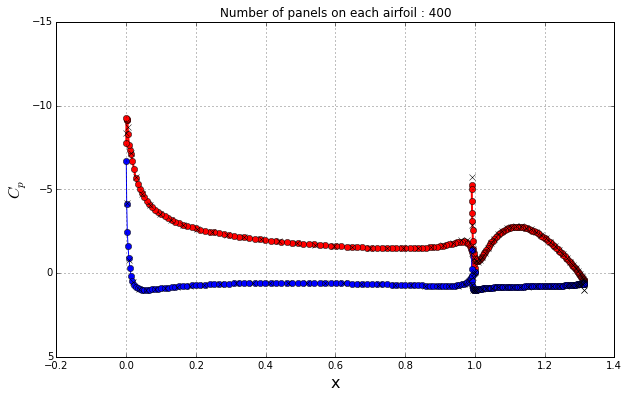

In [23]:
# plots the surface pressure coefficient
N = len(panels)
mains = panels[:N/2]
flaps = panels[N/2:]

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in mains if panel.loc == 'extrados'], 
         [panel.cp for panel in mains if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flaps if panel.loc == 'extrados'], 
         [panel.cp for panel in flaps if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in mains if panel.loc == 'intrados'], 
         [panel.cp for panel in mains if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flaps if panel.loc == 'intrados'], 
         [panel.cp for panel in flaps if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot(x_main, cp_main, 'kx', x_flap, cp_flap, 'kx')
pyplot.xlim(-0.2, 1.4)
pyplot.ylim(-15, 5)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels on each airfoil : %d' % N);

#### Eval Lift and drag

In [24]:
def eval_ld(panels):
    L = 0.
    D = 0.
    for panel in panels:
        L -= panel.cp*panel.length*panel.ny
        D += panel.cp*panel.length*panel.nx
    return L, D

In [25]:
Lift, Drag = eval_ld(panels)
print "Lift     Drag"
print Lift, Drag

Lift     Drag
3.71843390868 0.0055835520559


#### Questions in edx:

##### pressure coefficient on the 3rd panel on the main airfoil? 

In [26]:
print panels[2].cp

-0.553530359708


##### pressure coefficient on the 10th panel on the flap airfoil? 

In [27]:
N = len(panels)
print panels[N/2+9].cp

0.262580530047


####absolute error

In [28]:
abs_err = numpy.abs(3.7386-Lift)
print abs_err

0.0201660913188


In [31]:
print (abs100-abs_err)/abs100

0.506766949023


In [30]:
abs100 = 0.0408855231392

In [29]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/codefolding/main');

<IPython.core.display.Javascript object>